In [328]:
#%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
from astroquery.mast import Observations
import lightkurve
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table

### Reading in flare data for GJ1243 from Davenport et al (2014)

In [2]:
flare_table=pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/master/data/gj1243_master_flares.tbl',
            skiprows=23,delim_whitespace=True,names=['index of flare start in "gj1243_master_slc.dat"',
                                                   'index of flare stop in "gj1243_master_slc.dat"','t_start','t_stop'
                                                   ,'t_peak','t_rise','t_decay','flux peak',
                                                   'ED','Duration of rise',
                                                   'Duration of decay','Complex flag',
                                                   '# of people that identified flare event exists',
                                                   '# of people that analyzed this month',
                                                   '# of flare template components fit to event'])

In [3]:
t_starts=flare_table.loc[:,'t_start']
t_stops=flare_table.loc[:,'t_stop']
flux_peak = flare_table.loc[:,'flux peak']

### Importing in GJ1243 light curve (DR-25)

In [4]:
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '9726699'
gj1243_collection = search_lightcurvefile(target,cadence='short').download_all()

In [5]:
gj1243lc = gj1243_collection[0].PDCSAP_FLUX.remove_nans()

#stitching together the full light curve
for q in range(1,len(gj1243_collection)):
    try:
        gj1243lc = gj1243lc.append(gj1243_collection[q].PDCSAP_FLUX).remove_nans()
    except:
            print(q)

### Masking out the flares

In [6]:
f_mask = np.zeros_like(gj1243lc.time, dtype=bool)
for i in range(len(t_starts)):
    dur = t_stops[i] - t_starts[i]
    c1 = 0.25
    c2 = 0.5 #play with these buffers 
    buffer = (gj1243lc.time >= t_starts[i] - c1*dur) & (gj1243lc.time <= t_stops[i] + c2*dur)
    temp = (gj1243lc.time >= t_starts[i]) & (gj1243lc.time <= t_stops[i])
    f_mask = f_mask + buffer
print(f_mask)

[False False False ... False False False]


Text(0, 0.5, 'Normalized Flux')

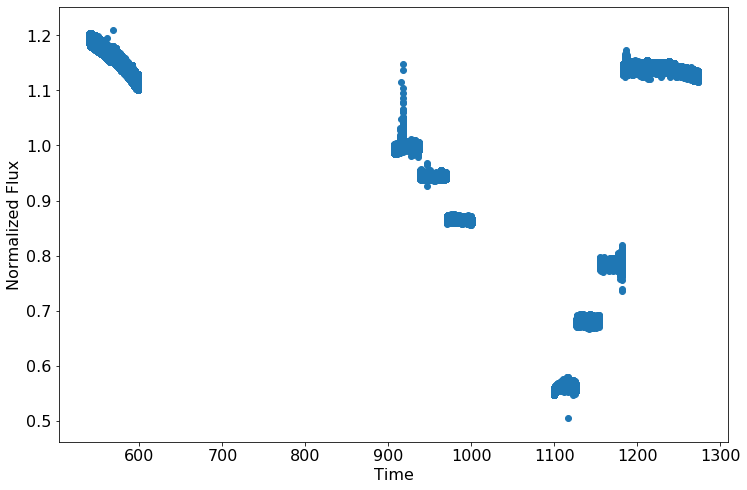

In [7]:
fig = plt.figure(figsize=(12,8))
font = {'size'   : 16}
plt.rc('font', **font)

no_flares = np.where((f_mask == False))[0]
plt.scatter(gj1243lc.time[no_flares],gj1243lc.flux[no_flares]/np.nanmedian(gj1243lc.flux[no_flares]))
#plt.xlim(539.4,540.4)
#plt.ylim(1.17,1.22)
#plt.xlim(1190,1200)
plt.xlabel('Time')
plt.ylabel('Normalized Flux')

In [8]:
extra_flares_table=pd.read_csv('extra_flares',skiprows=3,delim_whitespace=True,names=['t_start','t_stop'])
t_starts_extra=extra_flares_table.loc[:,'t_start']
t_stops_extra=extra_flares_table.loc[:,'t_stop']
#first one might be outlier
extra_flares_table

,t_start,t_stop
0,567.70,567.80
1,913.50,913.60
2,917.90,918.00
3,946.00,946.10
4,1178.80,1178.90
5,1181.58,1181.65
6,1185.50,1185.58


In [8]:
un_mes=gj1243_collection[0].PDCSAP_FLUX
f_mask_un_mes = np.zeros_like(un_mes.time, dtype=bool)

#mask array for one month of data
for i in range(len(t_starts)):
    dur = t_stops[i] - t_starts[i]
    c1 = 0. #was.25 & .5
    c2 = 0. #play with these buffers 
    buffer = (un_mes.time >= (t_starts[i] - c1*dur)) & (un_mes.time <= (t_stops[i] + c2*dur))
    temp = (un_mes.time >= t_starts[i]) & (un_mes.time <= t_stops[i])
    f_mask_un_mes = f_mask_un_mes + buffer
print(f_mask_un_mes)
no_flare_un_mes = np.where((f_mask_un_mes == False))[0]

[False False False ...  True False False]


In [11]:
no_flare_un_mes

array([    0,     1,     2, ..., 39623, 39628, 39629])

### Light curve with highlighted flares

Text(0.5, 0, 'Time - 2457000 [BTJD days]')

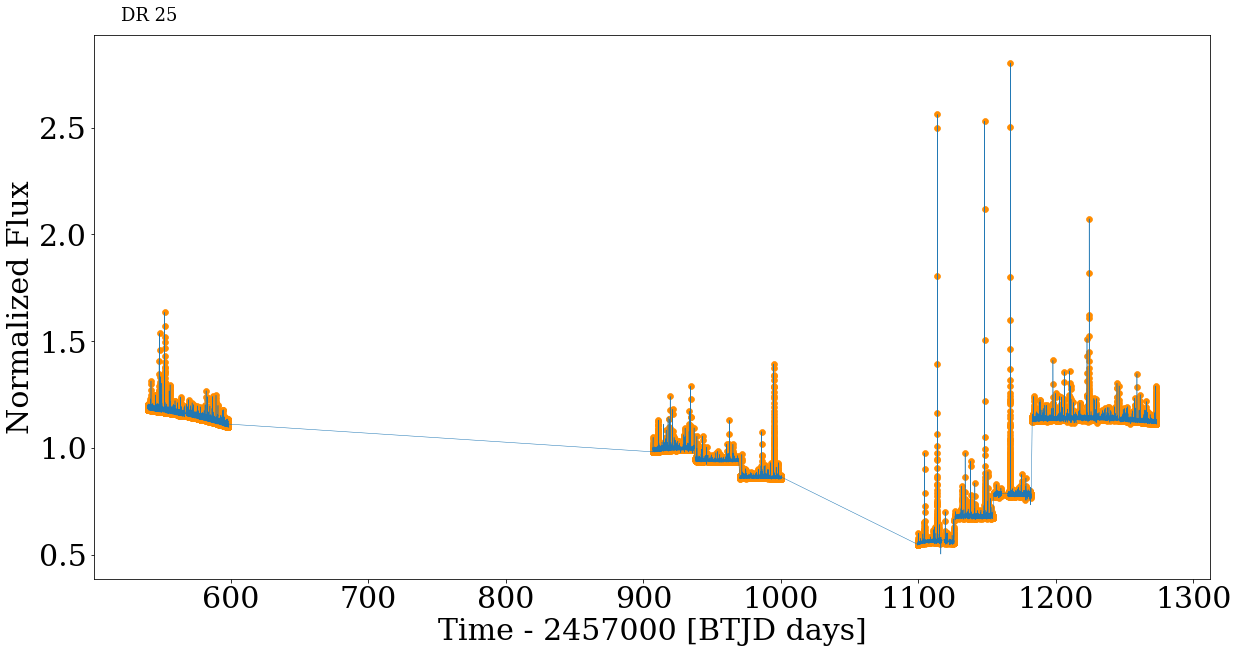

In [9]:
flares_x=gj1243lc.time[f_mask]
flares_y = gj1243lc.flux[f_mask]/np.nanmedian(gj1243lc.flux)

fig = plt.figure(figsize=(20,10))
import matplotlib
matplotlib.rcParams.update({'font.size':30})
matplotlib.rcParams.update({'font.family':'serif'})

fig.subplots_adjust(hspace=0.3, wspace=0.4)



plt.plot(gj1243lc.time[:84887],gj1243lc.flux[:84887]/np.nanmedian(gj1243lc.flux),linewidth=0.5,alpha=0.99,color='C0')
plt.plot(gj1243lc.time[84888:217976],gj1243lc.flux[84888:217976]/np.nanmedian(gj1243lc.flux),linewidth=0.5,color='C0',alpha=0.99)
plt.plot(gj1243lc.time[217976:],gj1243lc.flux[217976:]/np.nanmedian(gj1243lc.flux),linewidth=0.5,color='C0',alpha=0.99)


plt.scatter(flares_x,flares_y,linewidth=0.7,color='darkorange',s=35)




#Text
plt.text(520, 3, 'DR 25', fontsize=18, color ='k')



#fig.text(0.06, 0.5, 'Normalized Flux', ha='center', va='center', rotation='vertical')
#fig.text(0.5, 0.05, 'Time - 2457000 [BTJD days]', ha='center', va='center')

plt.ylabel("Normalized Flux")
plt.xlabel("Time - 2457000 [BTJD days]")


#plt.savefig('gj1243_keplerlc.pdf',dpi=300, bbox_inches='tight', pad_inches=0.5)

### Accounting for quarterly discontinuities

In [13]:
#month1 = 1+((gj1243_collection[0].PDCSAP_FLUX.flux[no_flare_un_mes] - np.nanmedian(gj1243_collection[0].PDCSAP_FLUX.flux[no_flare_un_mes]))/(np.nanmedian(gj1243lc.flux[no_flares])))
#month2 = 1+((gj1243_collection[1].PDCSAP_FLUX.flux[no_flare_un_mes]  - np.nanmedian(gj1243_collection[1].PDCSAP_FLUX.flux[no_flare_un_mes] ))/(np.nanmedian(gj1243lc.flux[no_flares] )))
#month3 = 1+((gj1243_collection[2].PDCSAP_FLUX.flux - np.nanmedian(gj1243_collection[2].PDCSAP_FLUX.flux))/(np.nanmedian(gj1243lc.flux)))
#month4 = 1+((gj1243_collection[3].PDCSAP_FLUX.flux - np.nanmedian(gj1243_collection[3].PDCSAP_FLUX.flux))/(np.nanmedian(gj1243lc.flux)))

In [10]:
i = 0
month1_median = np.nanmedian(gj1243_collection[i].PDCSAP_FLUX.flux[no_flare_un_mes])
total_median = np.nanmedian(gj1243lc.flux[no_flares])

month1_flux = 1 + (gj1243_collection[i].PDCSAP_FLUX.flux[no_flare_un_mes] - month1_median) / total_median

raw_flux = 1+((gj1243_collection[0].PDCSAP_FLUX.flux - np.nanmedian(gj1243_collection[0].PDCSAP_FLUX.flux[no_flare_un_mes]))/(np.nanmedian(gj1243lc.flux)))

In [41]:
medflux=np.array([])
for i in range(0,len(gj1243_collection)):
    try:
        med = 1+((gj1243_collection[i].PDCSAP_FLUX.flux - np.nanmedian(gj1243_collection[i].PDCSAP_FLUX.flux))/(np.nanmedian(gj1243lc.flux)))
        medflux = np.append(medflux,med)
    except:
            print(i)

In [12]:
print(len(un_mes.flux))#not averaged
print(len(month1_flux)) #has the correct averaging for flareless data

39630
28000


### GP

In [47]:
import celerite
y = month1_flux
t = un_mes.time[no_flare_un_mes]
yerr = 1+((gj1243_collection[0].PDCSAP_FLUX.flux_err[no_flare_un_mes] - np.nanmedian(gj1243_collection[0].PDCSAP_FLUX.flux[no_flare_un_mes]))/(np.nanmedian(gj1243lc.flux[no_flare_un_mes])))
yerr = np.sqrt(yerr**2 + np.nanmedian(pd.Series(y).rolling(10,center=True).std())**2)


# A non-periodic component
Q = 0.001
w0 = 2*np.pi/0.59
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15,15), log_Q=(-15,15), log_omega0=(-15,15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),bounds=bounds)
#kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

In [48]:
gj1243_collection[0].PDCSAP_FLUX.flux_err

array([83.01843 , 82.97698 , 82.96462 , ..., 79.520004, 78.98069 ,
       78.729614], dtype=float32)

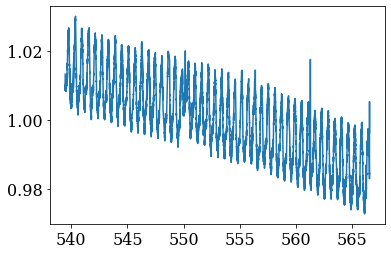

In [49]:
plt.plot(t,y)

<ErrorbarContainer object of 3 artists>

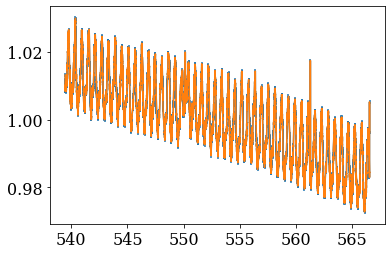

In [50]:
plt.errorbar(t,y,yerr=yerr)
plt.errorbar(t,y)

In [51]:
gp = celerite.GP(kernel, mean=np.mean(y),fit_mean=True)
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))

Initial log likelihood: 126498.12167499245
parameter_dict:
OrderedDict([('kernel:log_S0', -4.375628587868117), ('kernel:log_Q', -6.907755278982137), ('kernel:log_omega0', 2.3655098084917174), ('mean:value', 0.999515950679779)])

parameter_names:
('kernel:log_S0', 'kernel:log_Q', 'kernel:log_omega0', 'mean:value')

parameter_vector:
[-4.37562859 -6.90775528  2.36550981  0.99951595]

parameter_bounds:
[(-15, 15), (-15, 15), (-15, 15), (None, None)]



In [52]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)


      fun: -167922.37519706547
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.76252036, -0.13387762,  0.23283064,  0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 155
      nit: 26
   status: 0
  success: True
        x: array([-3.28164954, -3.02254714,  0.69309244,  1.00937299])


In [61]:
#running pred_var takes a long time
x= un_mes.time
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

In [13]:
#Reading in the GP
gp_vals=pd.read_csv('gp_values_1mo.csv')

In [26]:
#gp_vals #(time,mean,std,var)

In [14]:
fig = plt.figure(figsize=(12,8))
font = {'size'   : 16}
plt.rc('font', **font)

color = "#ff7f0e"
#plt.plot(gj1243lc.time[no_flare],gj1243lc.flux[no_flare]/np.nanmedian(gj1243lc.flux),  lw=1, alpha=0.5)
plt.errorbar(t, y, yerr=yerr, color='g')
plt.plot(gp_vals['time'], gp_vals['mean'], color=color)
plt.fill_between(gp_vals['time'], gp_vals['mean']+gp_vals['std'], gp_vals['mean']-gp_vals['std'], color=color, alpha=0.5,
                 edgecolor="none")
plt.xlabel("Time")
plt.ylabel("Flux")
#plt.xlim(539.5,565)
plt.xlim(539.45,539.870)
#plt.ylim(-2.5, 2.5);


plt.plot(un_mes.time[no_flare_un_mes],month1_flux, lw=1,alpha=0.5)

NameError: name 't' is not defined

<Figure size 864x576 with 0 Axes>

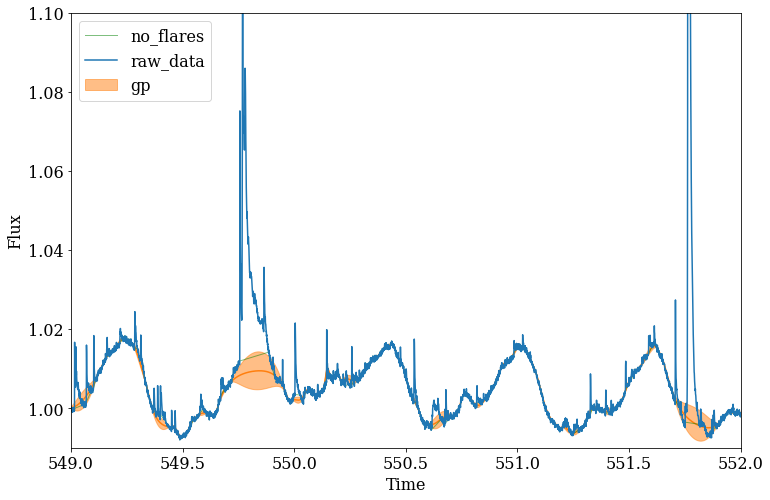

In [15]:
# A zoom in on just one month of the gp
fig = plt.figure(figsize=(12,8))
font = {'size'   : 16}
plt.rc('font', **font)

color = "#ff7f0e"
#plt.plot(gj1243lc.time[no_flare],gj1243lc.flux[no_flare]/np.nanmedian(gj1243lc.flux),  lw=1, alpha=0.5)
#plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(gp_vals['time'], gp_vals['mean'], color=color)
plt.fill_between(gp_vals['time'], gp_vals['mean']+gp_vals['std'], gp_vals['mean']-gp_vals['std'], color=color, alpha=0.5,
                 edgecolor="none",label='gp')
plt.xlabel("Time")
plt.ylabel("Flux")
plt.xlim(549,552)
#plt.xlim(539.45,539.870)
plt.ylim(0.99,1.1)
plt.plot(un_mes.time[no_flare_un_mes],month1_flux, lw=1,alpha=0.5,color='g',label='no_flares')
plt.plot(un_mes.time,raw_flux
        ,label='raw_data')
plt.legend()

### Saving gp outputs for Q1 to .csv file

In [27]:
# dictionary of lists  
# will not run w/o running the gp first 
dict = {'time':x,'mean': pred_mean, 'std': pred_std, 'var': pred_var}  
gp_out = pd.DataFrame(dict) 
gp_out.to_csv(r'/Users/lupitatovar/flares/notebooks/gp_values_1mo.csv',header=True,index=True)

NameError: name 'x' is not defined

### Fixing quarterly discontinuties

### Sample of Flares to stack
#### Criteria:
- 20-75 minutes duration
- no complex flares

In [16]:
complex_flag = flare_table['Complex flag'] #2=complex, 1 = classical
ED = flare_table['ED'] #units=seconds
flare_table['Flare_Duration'] = 1440.*(t_stops-t_starts) #units = minutes

In [30]:
#flare_table

In [17]:
# Separating the types of flares
classical = len([i for i in complex_flag if i < 2.0]) 
print ("The number of classical flares : " + str(classical)) 

cmplx = len([i for i in complex_flag if i > 1.0]) 
print ("The number of complex flares : " + str(cmplx)) 

complex_flares = flare_table[flare_table['Complex flag'] == 2.0]
classical_flares = flare_table[flare_table['Complex flag'] == 1.0]

#-----------------------------------------------------------------------------------------
min_dur = 20.0 #minutes
max_dur = 75.0

dur_limit = len([i for i in flare_table['Flare_Duration'] if i >= min_dur and i<max_dur]) 
print ("The number of total flares with a duration between 20-75min : " + str(dur_limit))

The number of classical flares : 5162
The number of complex flares : 945
The number of total flares with a duration between 20-75min : 1641


In [55]:
len(classical_flares)

5162

In [18]:
#adding in a column that is the flare duration into the table 
classical_flares['Flare_Duration'] = 1440.*(classical_flares['t_stop'] - classical_flares['t_start'])
#classical_flares

#classic_flare_dur = 1440.*(classical_flares['t_stop'] - classical_flares['t_start'])
len([i for i in classical_flares['Flare_Duration'] if i >= min_dur and i < max_dur])

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


902

### Stacking the Flares for one month

Stack the flares just in the first month (for now)

Plot [x,y] where x = time - peak time/ (t_(1/2) 

Y = detrended data / peak amplitude 

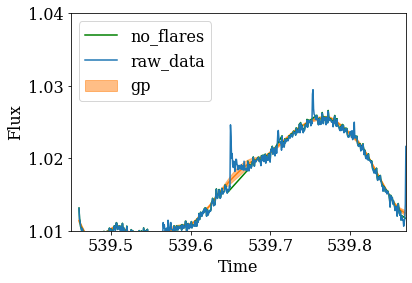

In [19]:
#zoom in on the first classical flare in the first quarter of data

oneflare_x = gj1243_collection[0].time
#oneflare_y = 1+((gj1243_collection[0].PDCSAP_FLUX.flux - np.nanmedian(gj1243_collection[0].PDCSAP_FLUX.flux))/(np.nanmedian(gj1243lc.flux)))
#plt.plot(oneflare_x,oneflare_y)
#plt.plot(gj1243_collection[0].time[f_mask_un_mes],
         #1+((gj1243_collection[0].PDCSAP_FLUX.flux[f_mask_un_mes] - np.nanmedian(gj1243_collection[0].PDCSAP_FLUX.flux[f_mask_un_mes]))/(np.nanmedian(gj1243lc.flux))), 
         #color='orange', alpha=0.5)

#plt.xlim(539.646668,539.671143)
plt.xlim(539.45,539.870)
plt.ylim(1.01,1.04)
plt.plot(gp_vals['time'], gp_vals['mean'], color=color)
plt.fill_between(gp_vals['time'], gp_vals['mean']+gp_vals['std'], gp_vals['mean']-gp_vals['std'], color=color, alpha=0.5,
                 edgecolor="none",label='gp')
plt.xlabel("Time")
plt.ylabel("Flux")

plt.plot(un_mes.time[no_flare_un_mes],month1_flux,color='g',label='no_flares')
plt.plot(un_mes.time,raw_flux,label='raw_data')
plt.legend()

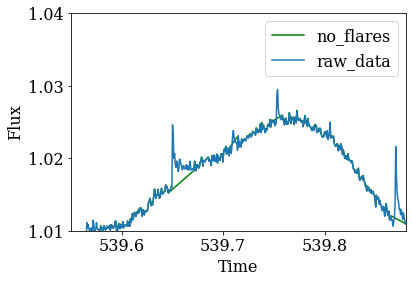

In [20]:
plt.xlim(539.55,539.88)
plt.ylim(1.01,1.04)
plt.xlabel("Time")
plt.ylabel("Flux")

plt.plot(un_mes.time[no_flare_un_mes],month1_flux,color='g',label='no_flares')
plt.plot(un_mes.time,raw_flux,label='raw_data')
plt.legend()

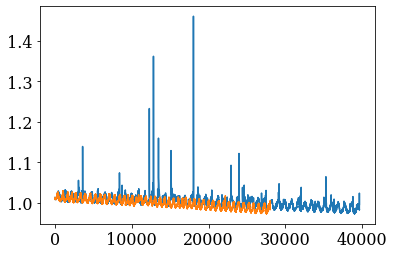

In [22]:
plt.plot(raw_flux,label='raw_data')
plt.plot(month1_flux)

#could it be buffer added to the start/end of the flares that is causing the offset?

flare-less data matches with the gp but there is an offset with the raw data still..

In [274]:
i = 0
month1_median = np.nanmedian(gj1243_collection[i].PDCSAP_FLUX.flux[no_flare_un_mes])
total_median = np.nanmedian(gj1243lc.flux[no_flares])

month1_flux = 1 + (gj1243_collection[i].PDCSAP_FLUX.flux[no_flare_un_mes] - month1_median) / total_median

raw_flux = 1+((gj1243_collection[0].PDCSAP_FLUX.flux - np.nanmedian(gj1243_collection[0].PDCSAP_FLUX.flux[no_flare_un_mes]))/(np.nanmedian(gj1243lc.flux)))

detrended_unmes = raw_flux-gp_vals['mean']


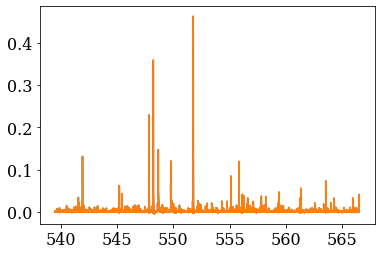

In [275]:
#detrended_unmes still includes the flares

#detrended_unmes = (1+((gj1243_collection[0].PDCSAP_FLUX.flux - np.nanmedian(gj1243_collection[0].PDCSAP_FLUX.flux))/(np.nanmedian(gj1243lc.flux))))-gp_vals['mean']
plt.plot(gp_vals['time'],detrended_unmes)
plt.plot(un_mes.time,detrended_unmes)
#plt.xlim(539,540)
#plt.ylim(-0.01,0.01)

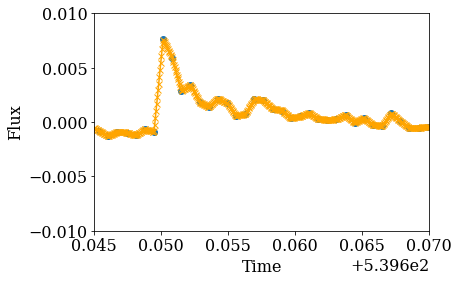

In [276]:
#subtracting the gp
oneflare_x = gj1243_collection[0].time
plt.scatter(oneflare_x,detrended_unmes)
#avg that includes the flares

#plt.xlim(539.646668,539.671143)
plt.xlim(539.645,539.670)
plt.ylim(-.01,0.01)

#plt.plot(x, pred_mean, color=color)
#plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.5,
                 #edgecolor="none")
plt.xlabel("Time")
plt.ylabel("Flux")

xvals = np.linspace(539.645, 539.67, 500)
yinterp = np.interp(xvals, oneflare_x, detrended_unmes)
plt.plot(xvals,yinterp,'-x',color='orange')

In [103]:
#flux position of t_half
print((classical_flares.t_peak[1] - classical_flares.t_start[1])/2)

print((classical_flares.t_peak[1] - classical_flares.t_stop[1])/2)

#time position of t_half
print((classical_flares.t_peak[1] + classical_flares.t_start[1])/2)
print((classical_flares.t_peak[1] + classical_flares.t_stop[1])/2)

0.0016784499999857871
-0.010559100000023136
539.64834595
539.6605835


In [30]:
peak = max(yinterp)  # Find the maximum y value
xs = [x for x in range(500) if yinterp[x] > peak/2.0]
print(min(xs), max(xs)) # Print the points at half-maximum

#T_1/2 is the duration of last from the first one  (now that I have found the midpoints)

98 123


In [133]:
print(yinterp[98]) #furthest point on the one flare of the t_half on the interpolated data
print(yinterp[123])
print(np.interp(yinterp[98], yinterp,xvals,period=1))
print(np.interp(yinterp[123], yinterp,xvals,period=1))

0.003928015098724153
0.0035028304141460458
539.6499098196392
539.6511623246492


In [26]:
x_thalf1= np.interp(yinterp[98], yinterp,xvals,period=1)
x_thalf2= np.interp(yinterp[123], yinterp,xvals,period=1)
print(x_thalf2 - x_thalf1) #this gives the difference in time between the t_half points of the interpolation

0.001252505010029381


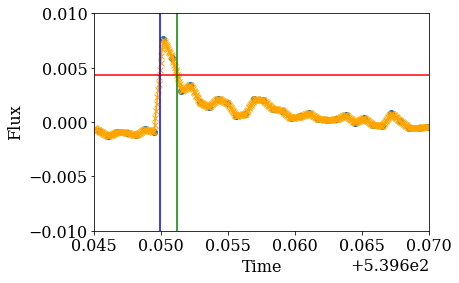

In [277]:
#subtracting the gp

plt.scatter(oneflare_x,detrended_unmes)
#avg that includes the flares

#plt.xlim(539.646668,539.671143)
plt.xlim(539.645,539.670)
plt.ylim(-.01,0.01)

#plt.plot(x, pred_mean, color=color)
#plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.5,
                 #edgecolor="none")
plt.xlabel("Time")
plt.ylabel("Flux")

xvals = np.linspace(539.645, 539.67, 500)
yinterp = np.interp(xvals, oneflare_x, detrended_unmes)
plt.plot(xvals,yinterp,'-x',color='orange')
plt.axhline(y=yinterp[123], color='r', linestyle='-')
plt.axvline(x=x_thalf1, color='b', linestyle='-')
plt.axvline(x=x_thalf2, color='g', linestyle='-')

In [33]:
#classical_flares

In [34]:
print(classical_flares['Flare_Duration'][1]) #minutes
print(classical_flares['t_peak'][1]) #days
print(classical_flares['flux peak'][1])

35.2441440000257
539.6500244
0.005732800000000001


In [44]:
len(oneflare_x)

39630

One stacked flare

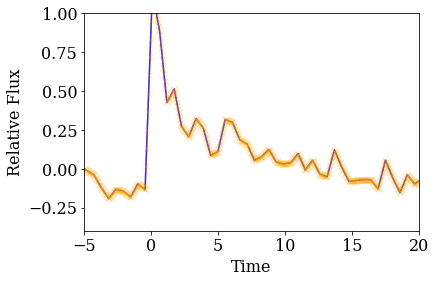

In [278]:
# t_half = half of the max (peak)
# similar to fwhm on photometry
#x_stack = (classical_flares['Flare_Duration'] - classical_flares['t_peak']) / (x_thalf2 - x_thalf1)
#y_stack = x_stack / classical_flares['t_peak']

tempx = (oneflare_x - classical_flares['t_peak'][1]) / (x_thalf2 - x_thalf1)
tempy = (detrended_unmes)/peak
plt.plot(tempx,tempy,color='b',alpha=1)


plt.xlabel('Time')
plt.ylabel('Relative Flux')
plt.ylim(-0.4,1)
plt.xlim(-5,20)
#plt.xlim(-5,20)
# peak time is in the fbeye file (that is what is used for Jim's plot)
# peak amplitude (also in the fbeye file but we want to calculate it for future work)

interp_xvals = np.linspace(-5,20, 500)
interp_yvals = np.interp(interp_xvals, tempx, (detrended_unmes/peak))
plt.plot(interp_xvals,interp_yvals,'-x',color='orange',alpha=.3)

### Interpolating over one month of data

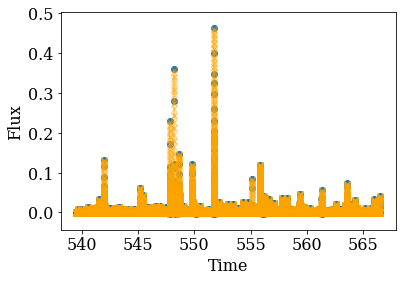

In [279]:
#interpolating the full light curve
plt.scatter(oneflare_x,detrended_unmes)
#avg that includes the flares

#plt.xlim(539.645,539.69)
#plt.xlim(539.645,539.670)
#plt.ylim(-.01,0.01)

#plt.plot(x, pred_mean, color=color)
#plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.5,
                 #edgecolor="none")
plt.xlabel("Time")
plt.ylabel("Flux")

padding_factor = 10
steps = padding_factor*len(detrended_unmes)

month1_xvals = np.linspace(539.460, 566.534, steps)
month1_yinterp = np.interp(month1_xvals, oneflare_x, detrended_unmes)
plt.plot(month1_xvals,month1_yinterp,'-x',color='orange',alpha=0.5)

### Stacking one month of flares

First we need to find the peaks of the interpolated data (i.e the max flux of all the flares)

In [412]:
#first quarter of flares runs from times ~539-567

#creating a table of month 1 flares

month1_flares = classical_flares[classical_flares['t_stop'] < 567]

#quarter one classical flares that are between 20-75 minutes
m1_dur_limit = len([i for i in month1_flares['Flare_Duration'] if i >= min_dur and i<max_dur]) 
print ("The number of total flares with a duration between 20-75min : " + str(month1_flares_dur_limit))

## This is a table of the first month of flares between the time limits set in Davenport (2014)
m1_flares_dur_limit = month1_flares[(month1_flares['Flare_Duration'] >= min_dur) & (month1_flares['Flare_Duration'] < max_dur)]
#m1_flares_dur_limit

The number of total flares with a duration between 20-75min : 127


In [413]:
#m1_flares_dur_limit

In [414]:
m1_flares_dur_limit['flux peak'][1] 

0.005732800000000001

In [114]:
np.amax(month1_yinterp)

0.45901534008668887

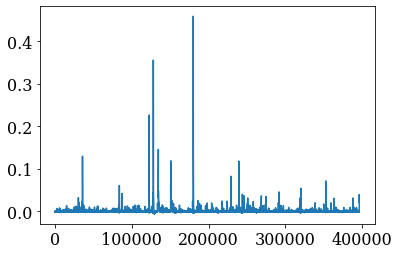

In [120]:
plt.plot(month1_yinterp)

In [154]:
len(m1_flares_dur_limit)

127

In [168]:
i=1
month1_xvals < m1_flares_dur_limit['t_stop'].values[i]

array([ True,  True,  True, ..., False, False, False])

In [161]:
m1_flares_dur_limit['t_stop'][1]

539.6711426

Finding the flux and time values where local maxes occur w/in interpolated data (i.e where the flares happen)

In [326]:
time_max=np.array([])
peaks = np.array([])
t_halfs = np.array([])
for i in range(0,len(m1_flares_dur_limit)):
    #this (temp1) is for the interpolated data
    temp1 = np.where((month1_xvals < m1_flares_dur_limit['t_stop'].values[i]) & 
                    (month1_xvals > m1_flares_dur_limit['t_start'].values[i]))[0]
    
    #this (temp2) is for normal data
    temp2 = np.where((oneflare_x < m1_flares_dur_limit['t_stop'].values[i]) & 
                    (oneflare_x > m1_flares_dur_limit['t_start'].values[i]))[0]
    i_max = np.argmax(detrended_unmes.values[temp2])
    t_max = (oneflare_x[temp2][i_max])
    flux_max = (detrended_unmes.values[temp2][i_max])
    time_max = np.append(time_max,t_max)
    
    peaks = np.append(peaks,flux_max)
    half_peaks = peaks/2.0
    
    i_xs = np.where((month1_yinterp[temp1] > half_peaks[i]))[0]
    time_xs = month1_xvals[temp1][i_xs]
    t_half = max(time_xs) - min(time_xs)
    t_halfs = np.append(t_halfs,t_half)
    
    #plot t_half for each flare, 
    


In [421]:
m1_flares_dur_limit['t_start'][1]

539.6466675

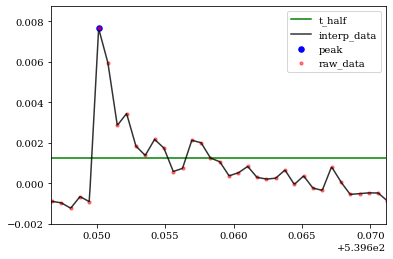

In [443]:
#plt.scatter(time_max,t_halfs,color='orange',label='t_half',s=10)
plt.axhline(y=t_halfs[1], color='green', linestyle='-',label='t_half')
plt.scatter(time_max,peaks,color='blue',label='peak',s=30)
plt.plot(month1_xvals,month1_yinterp,color='black',alpha=0.8,label='interp_data')
plt.scatter(oneflare_x,detrended_unmes,color='red',alpha=0.5,s=10,label='raw_data')
#plt.xlim(539.645,539.670)
plt.ylim(-.002,m1_flares_dur_limit['flux peak'][1]+.003)
plt.xlim(m1_flares_dur_limit['t_start'][1],m1_flares_dur_limit['t_stop'][1])
plt.legend()

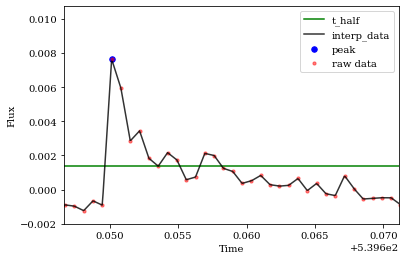

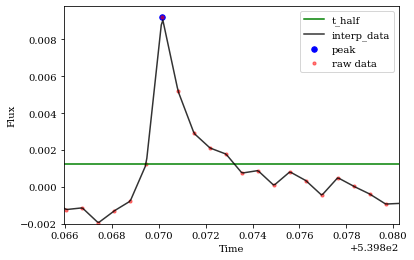

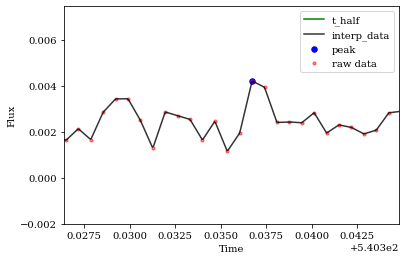

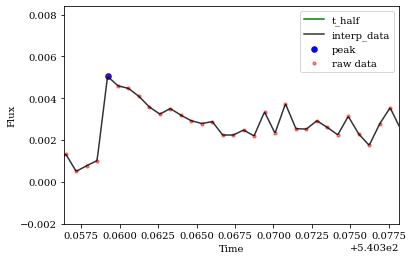

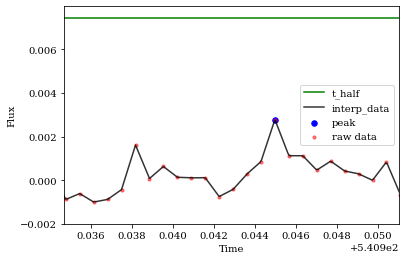

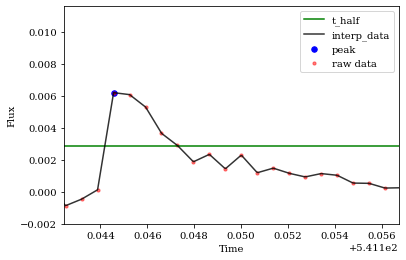

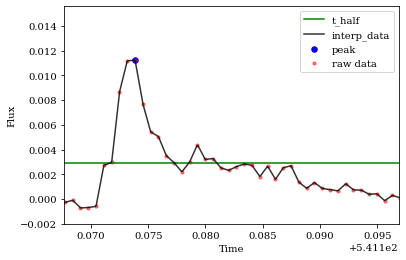

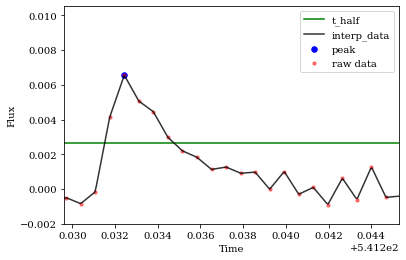

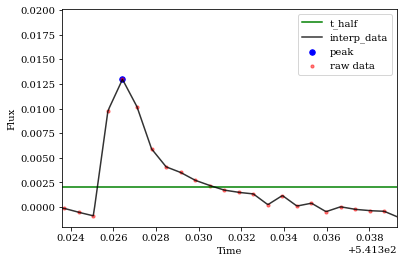

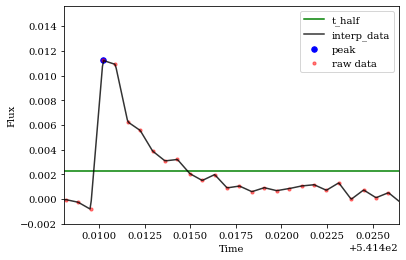

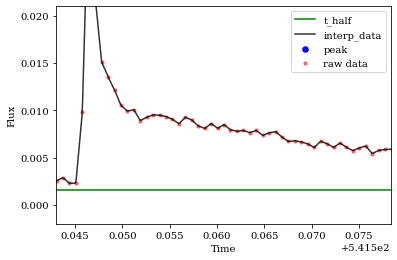

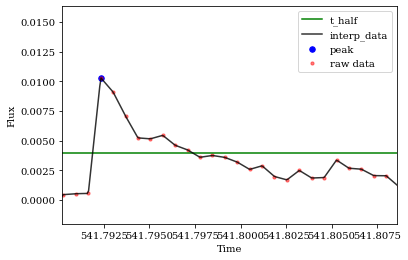

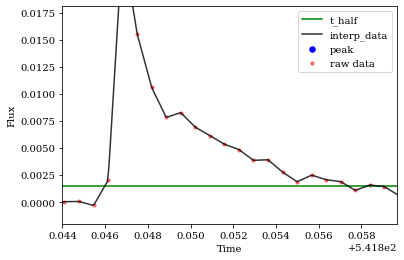

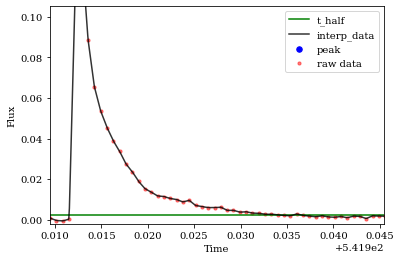

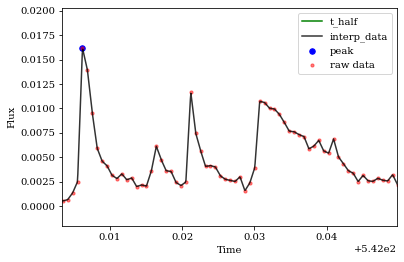

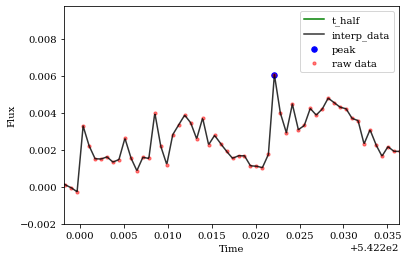

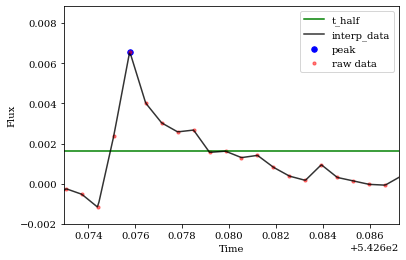

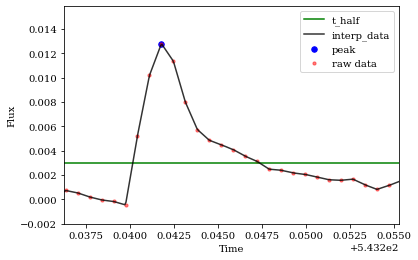

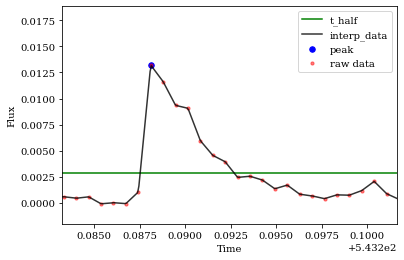

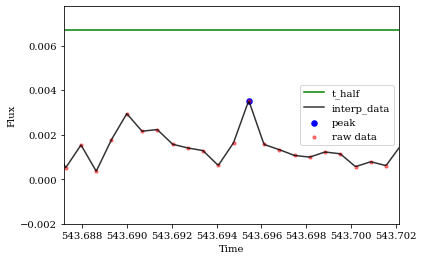

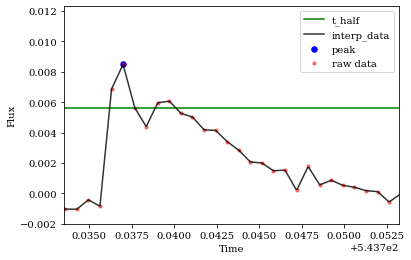

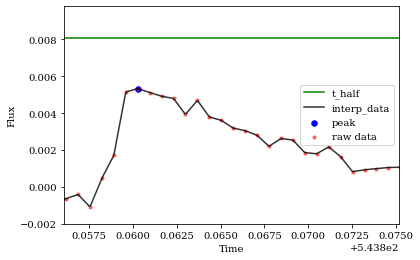

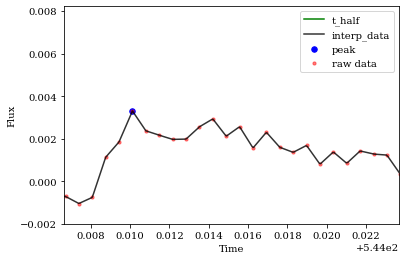

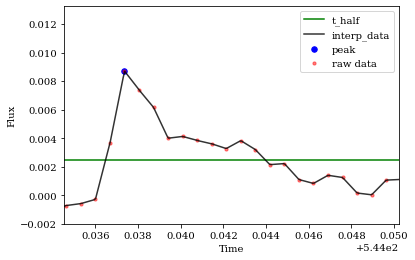

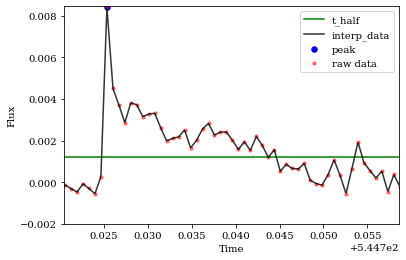

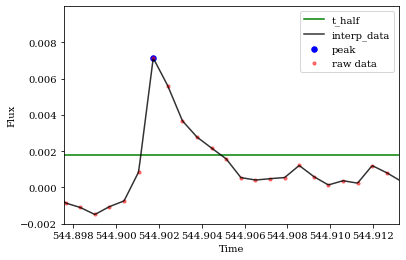

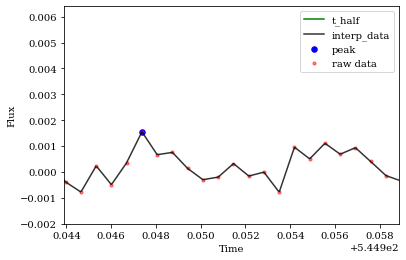

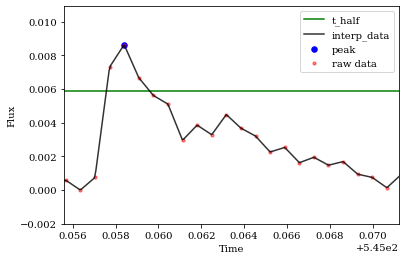

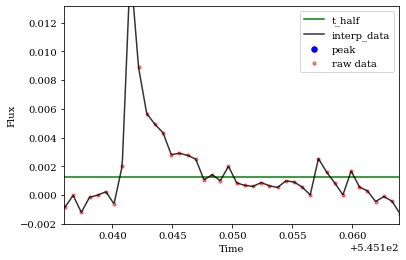

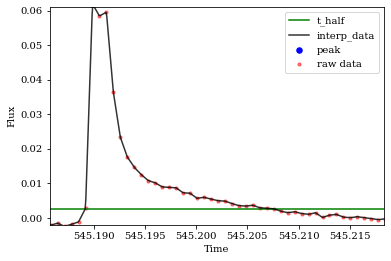

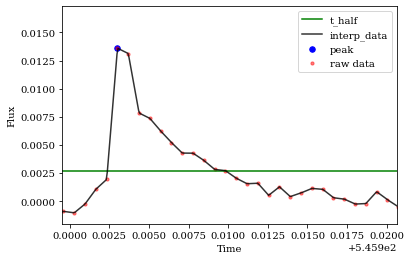

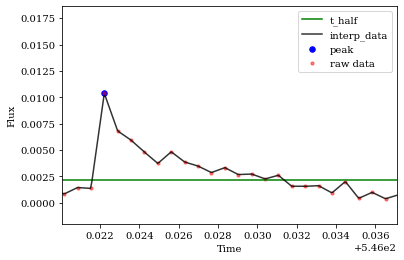

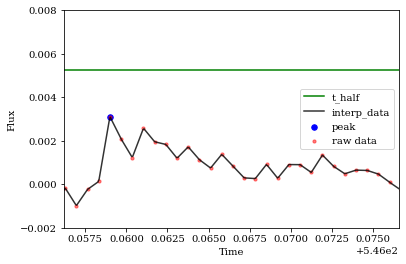

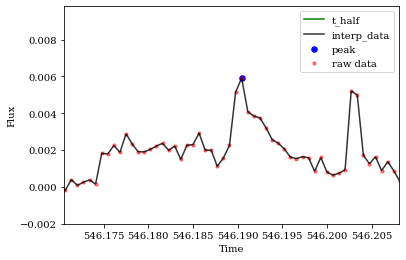

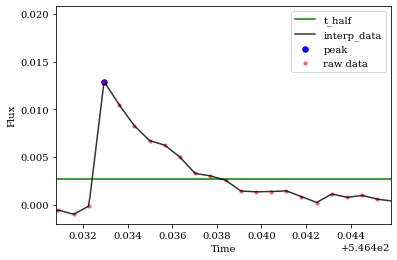

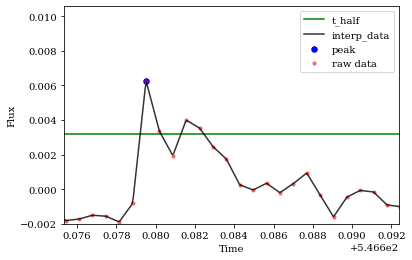

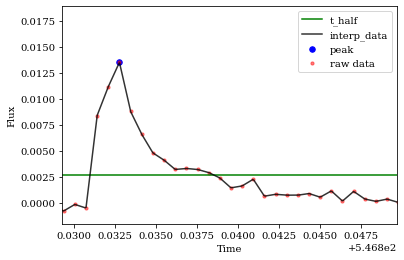

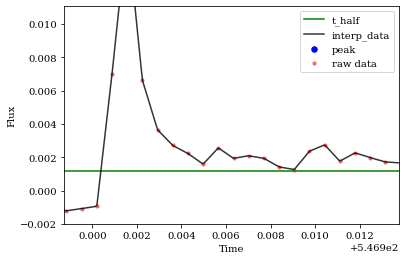

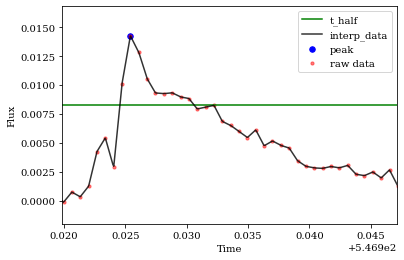

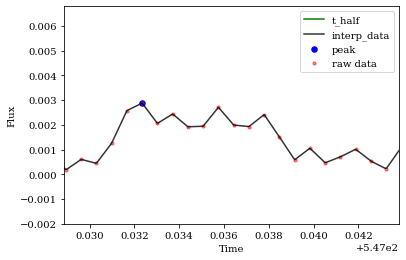

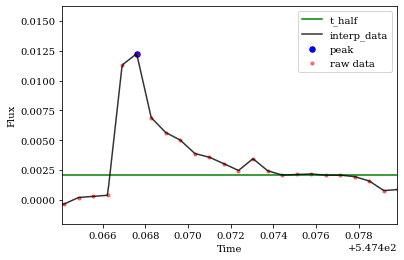

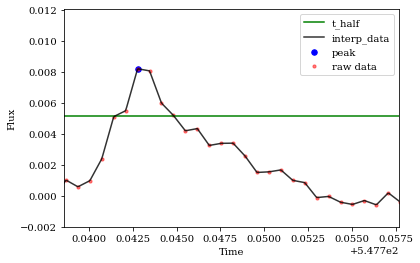

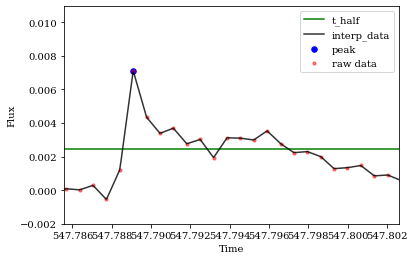

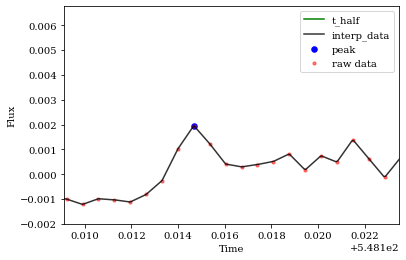

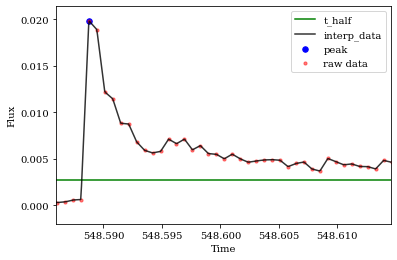

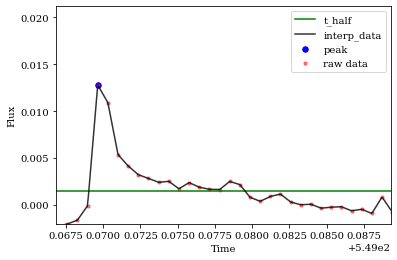

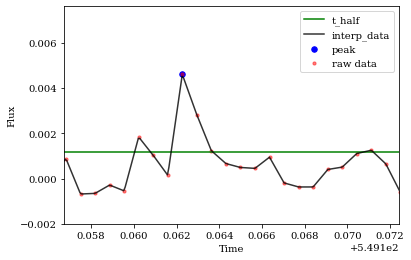

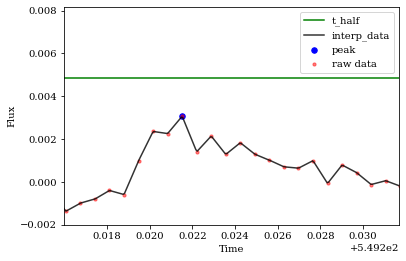

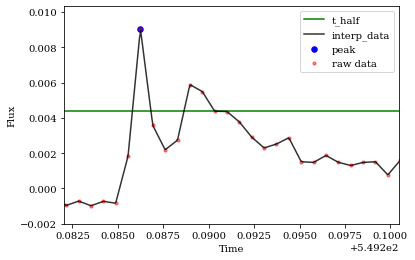

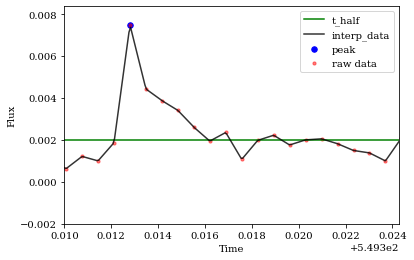

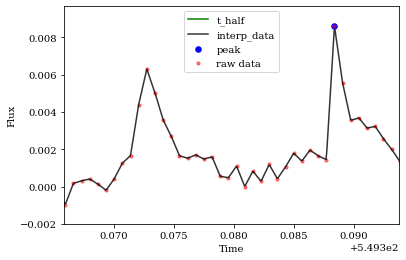

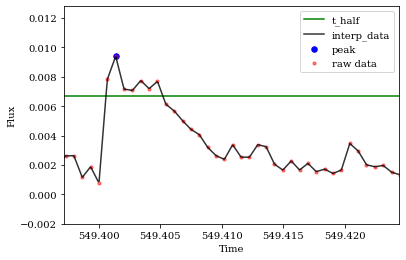

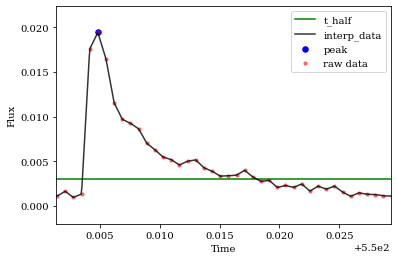

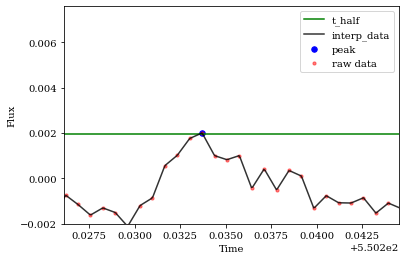

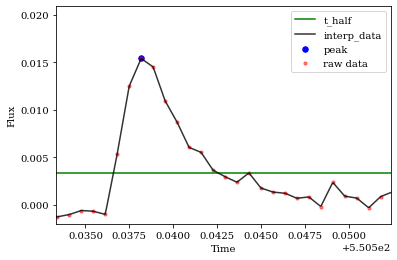

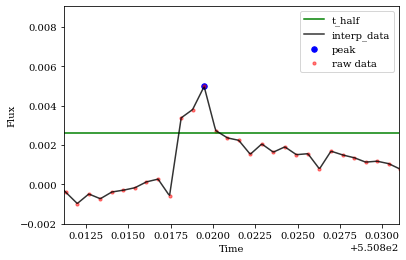

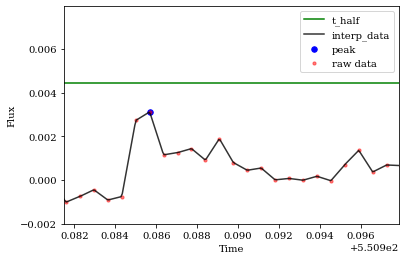

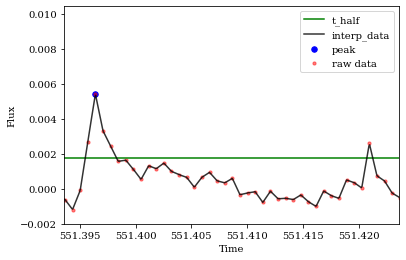

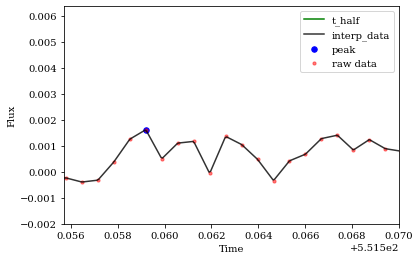

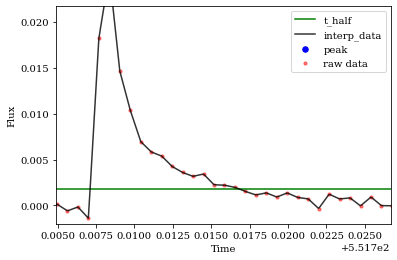

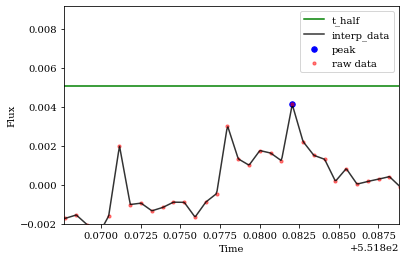

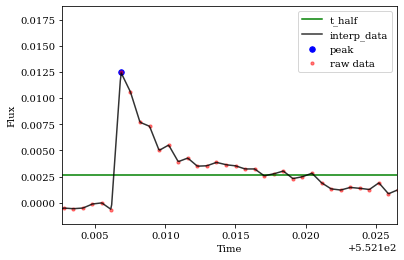

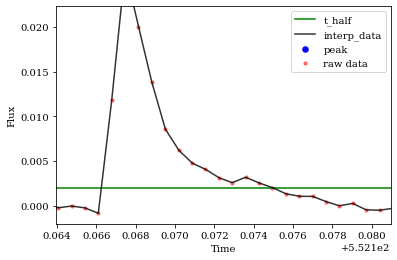

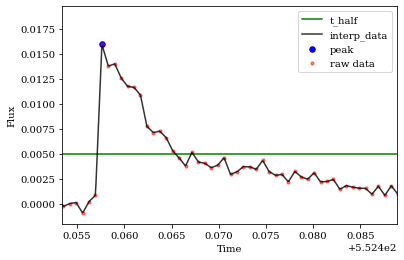

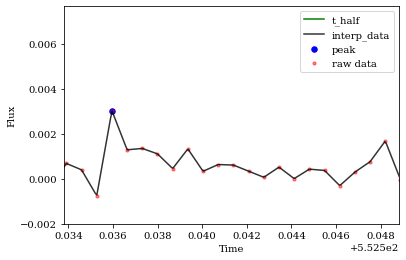

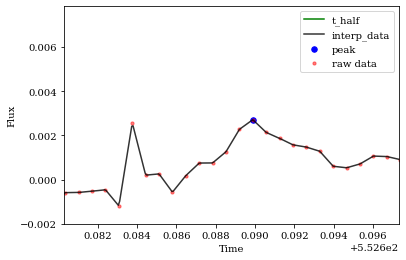

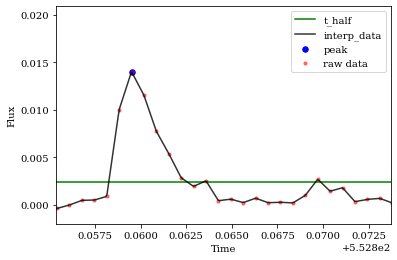

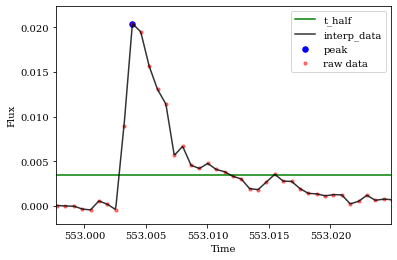

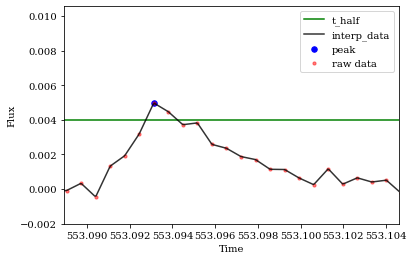

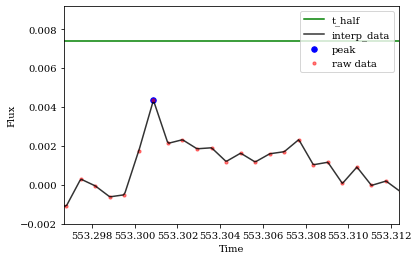

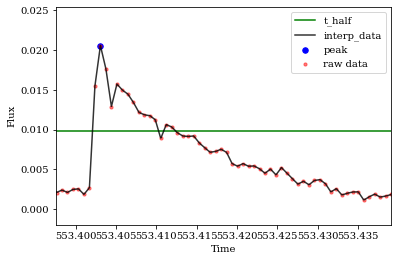

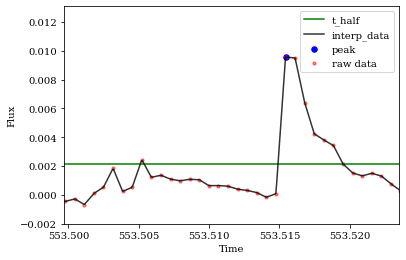

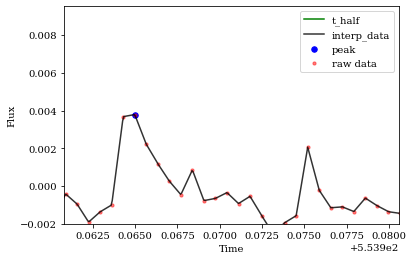

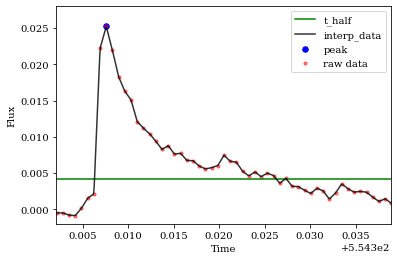

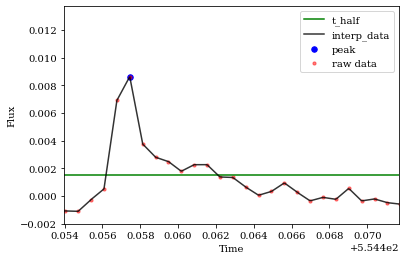

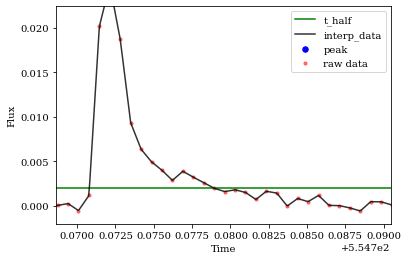

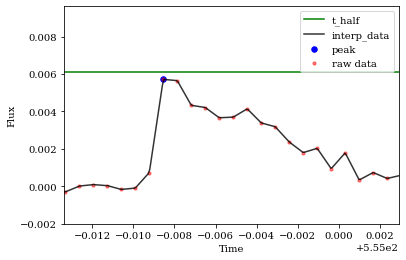

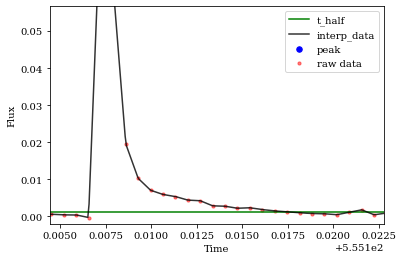

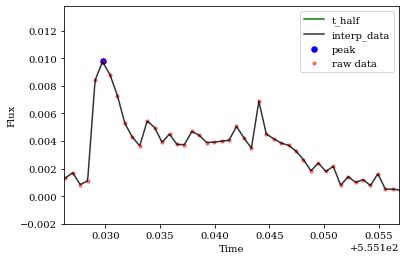

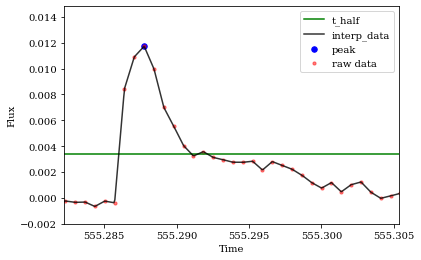

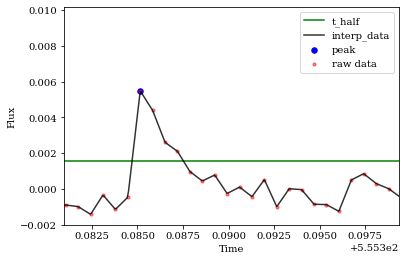

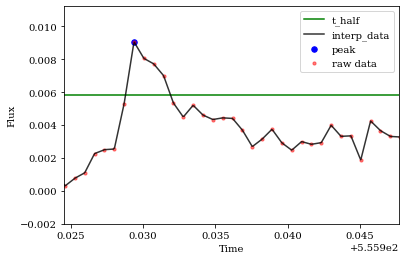

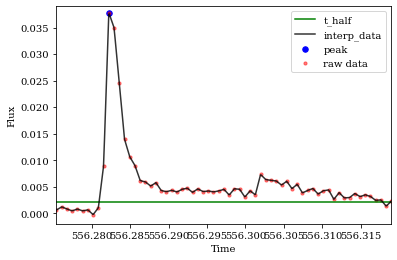

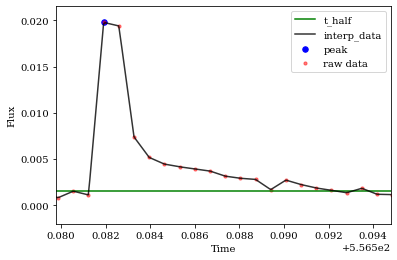

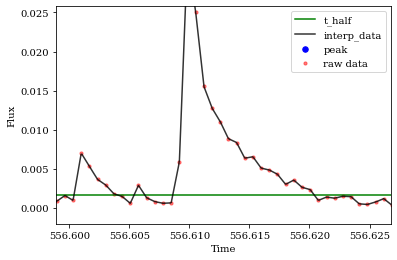

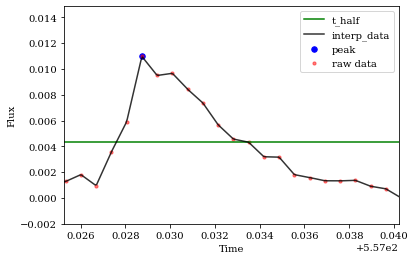

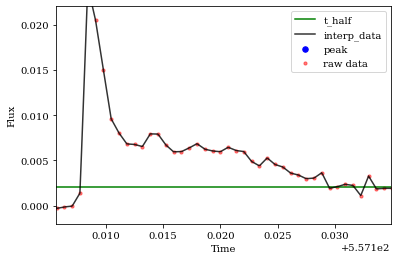

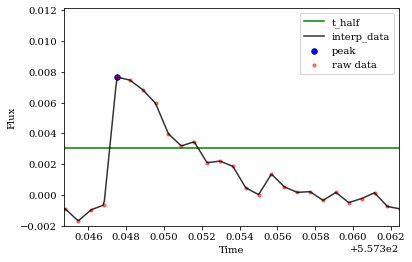

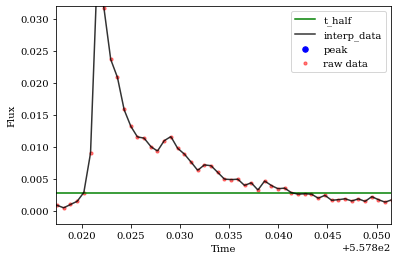

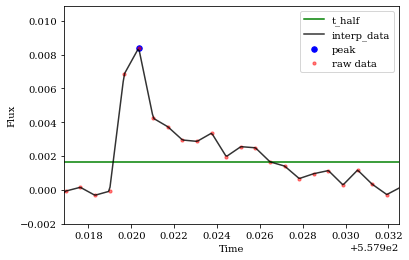

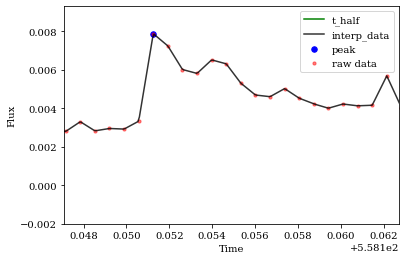

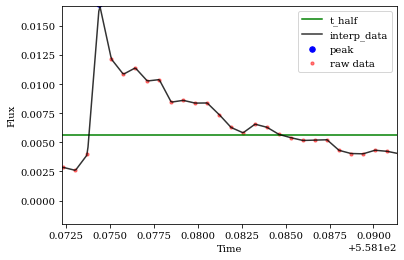

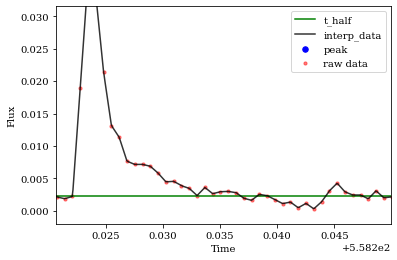

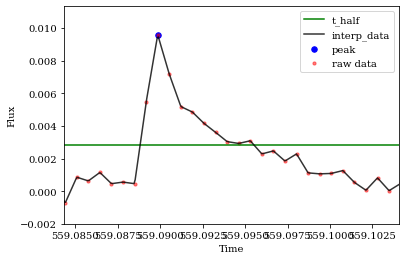

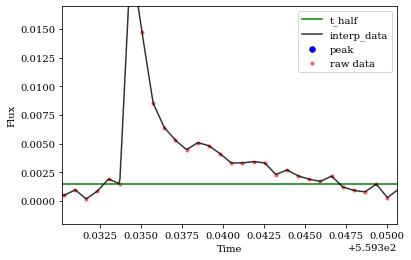

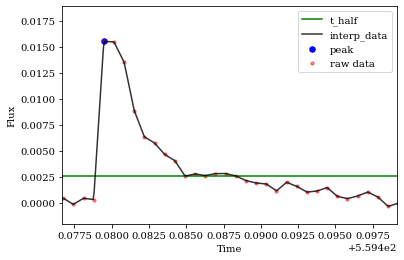

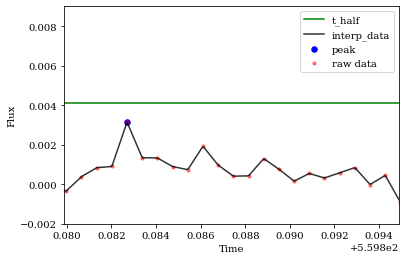

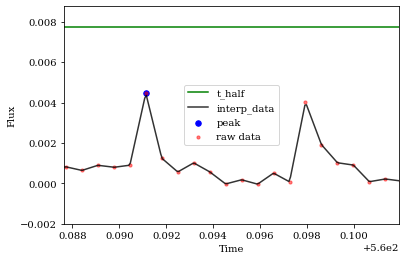

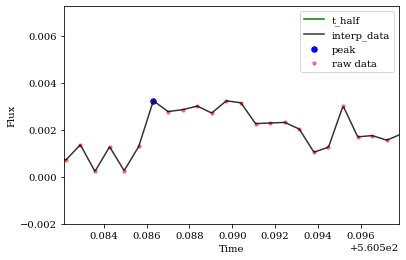

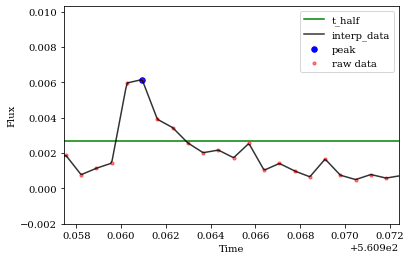

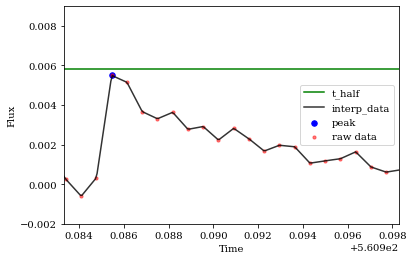

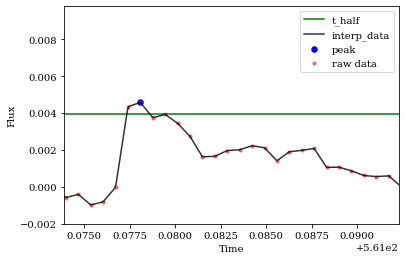

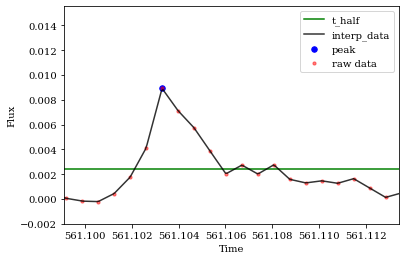

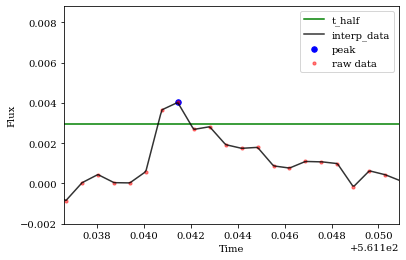

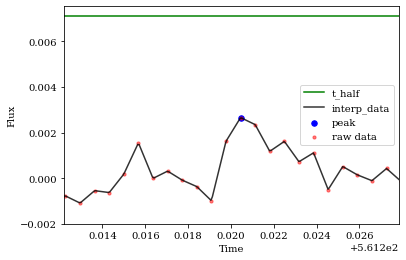

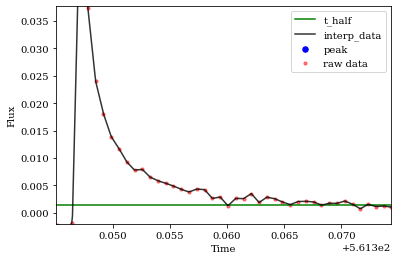

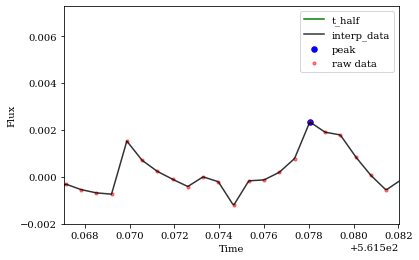

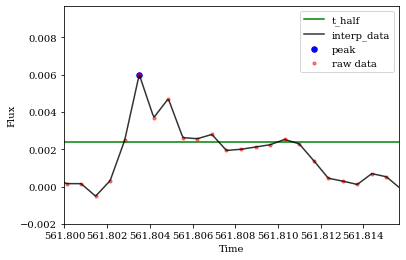

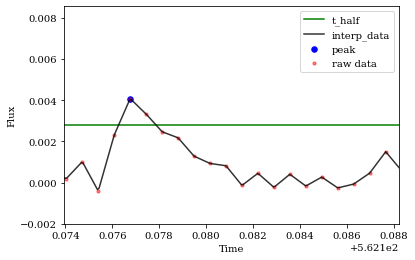

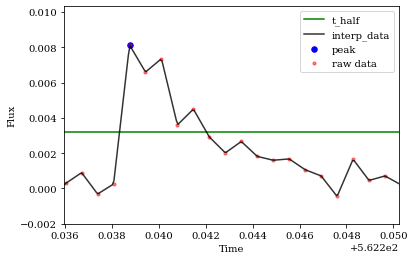

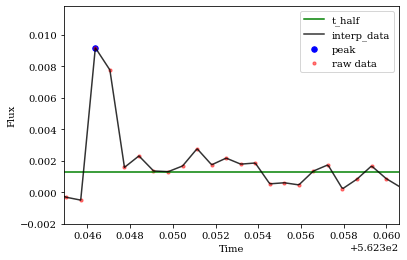

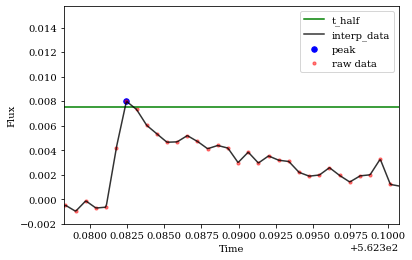

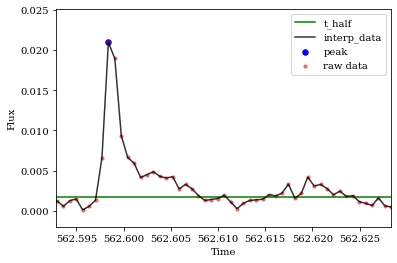

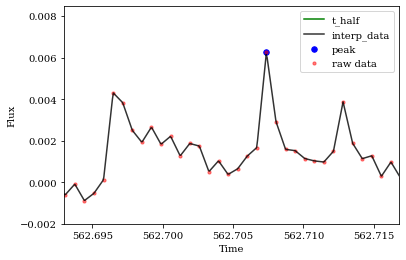

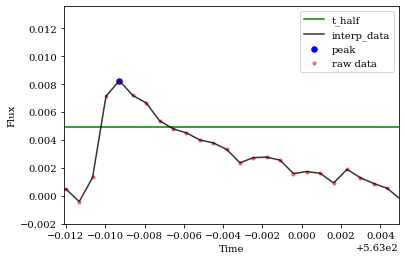

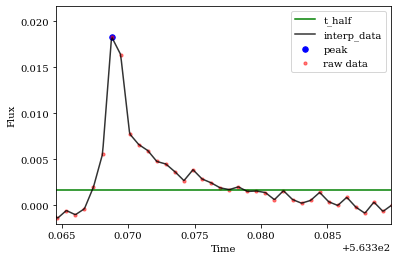

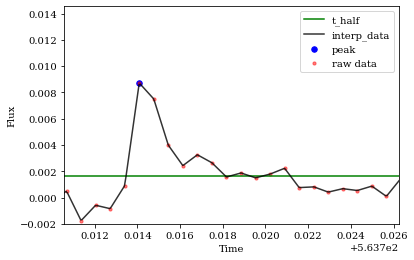

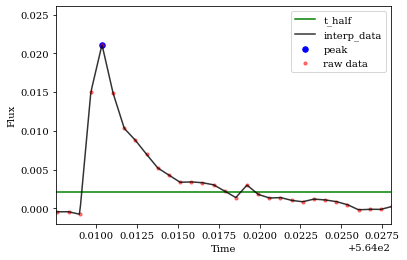

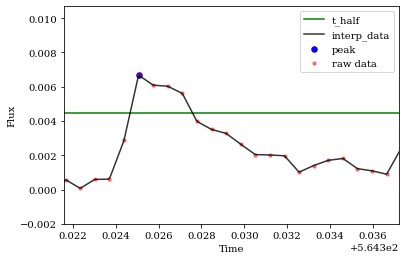

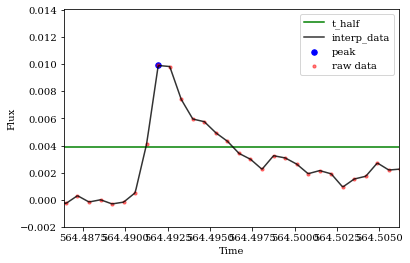

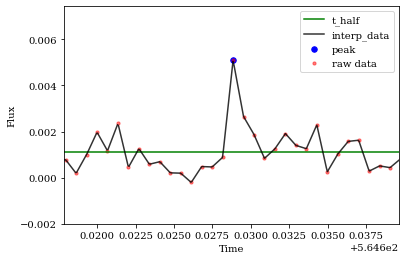

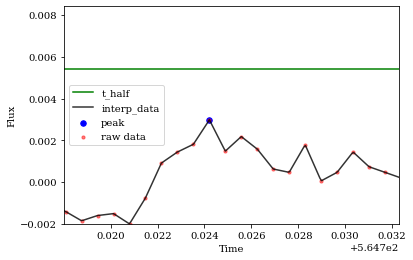

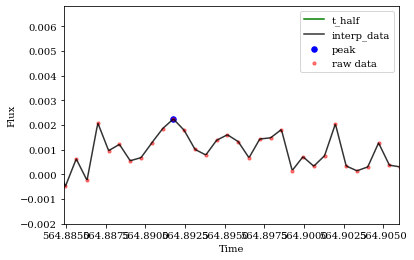

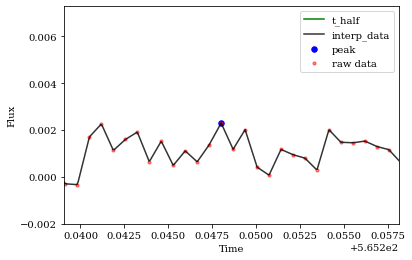

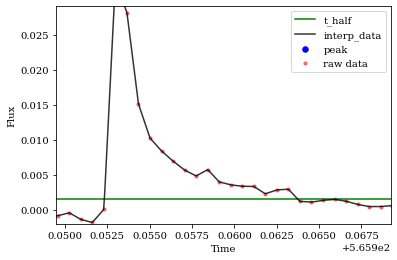

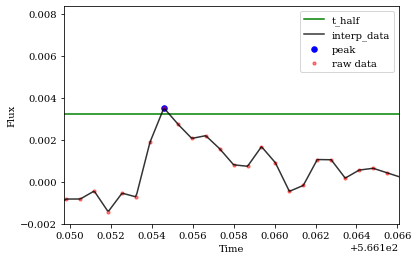

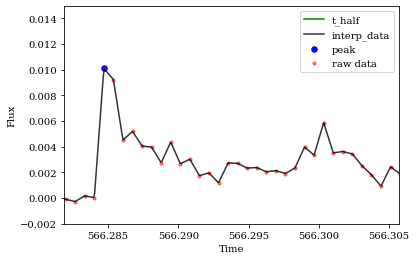

In [452]:
for i in range(0,len(m1_flares_dur_limit)):
    plt.figure()

    plt.axhline(y=t_halfs[i], color='green', linestyle='-',label='t_half')
    plt.scatter(time_max[i],peaks[i],color='blue',label='peak',s=30)
    plt.plot(month1_xvals,month1_yinterp,color='black',alpha=0.8,label='interp_data')
    plt.scatter(oneflare_x,detrended_unmes,color='red',alpha=0.5,s=10,label='raw data')
    plt.xlim(m1_flares_dur_limit['t_start'].values[i],m1_flares_dur_limit['t_stop'].values[i])
    plt.ylim(-.002,m1_flares_dur_limit['flux peak'].values[i]+.005)
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Flux')
    
    plt.show()

In [218]:
half_peaks = peaks/2.0
print(len(half_peaks))

127


In [371]:
''''
halfpeak_xs_min=np.array([])
halfpeak_xs_max=np.array([])
for i in range(0,len(m1_flares_dur_limit)):
    temp = np.where((month1_xvals < m1_flares_dur_limit['t_stop'].values[i]) & 
                    (month1_xvals > m1_flares_dur_limit['t_start'].values[i]))
    i_max = np.argmax(month1_yinterp[temp])
    min_xs = month1_xvals[half_peaks.argmin()]
    max_xs = month1_xvals[half_peaks.argmax()]
    halfpeak_xs_min =np.append(halfpeak_xs_min,min_xs)
    halfpeak_xs_max =np.append(halfpeak_xs_max,max_xs)
    print(halfpeak_xs_max)
''''

SyntaxError: EOL while scanning string literal (<ipython-input-371-ee3b968e49ff>, line 13)

In [150]:
#from scipy.signal import argrelextrema
#(argrelextrema(month1_yinterp, np.greater)[0])
#print(len(argrelextrema(month1_yinterp, np.greater)[0]))
#i=1
#m1_flares_dur_limit['t_start'][i],m1_flares_dur_limit['t_stop'][i]
#m1_peaks=np.array([])
#m1_peaks = np.append(m1_peaks,p)
#for i in range (0,1):
    #print(argrelextrema(month1_yinterp, np.greater)[0])
    
    #this gives the index of the local maxes

[    62     91    111 ... 396239 396259 396289]


In [284]:
#for i in range(0,len(m1_flares_dur_limit)):
#time_xs = [x for x in range(steps) if month1_yinterp[x] > half_peaks[1]] #this gives time locations on either side of flares
#printing the min and max(time_xs) gives the corresponding x_values (the ones we eventually subtract)
#print(time_xs)

In [ ]:
def t_half():
    #peaks = max(yinterp)  # Find the maximum y value
    time_xs = [x for x in range(steps) if month1_yinterp[x] > half_peaks]
    #print(min(xs), max(xs)) # Print the points at half-maximum
    x1s = np.array([])
    x2s = np.array ([])
    thalf_x1s = (np.interp(month1_yinterp[min(time_xs)], month1_yinterp,month1_xvals,period=1))
    thalf_x2s = (np.interp(month1_yinterp[max(time_xs)], month1_yinterp,month1_xvals,period=1))
    
    x1s = np.append(x1s,thalf_x1s)
    x2s = np.appen(x2s,thalf_x2s)
    return x2s - x1s

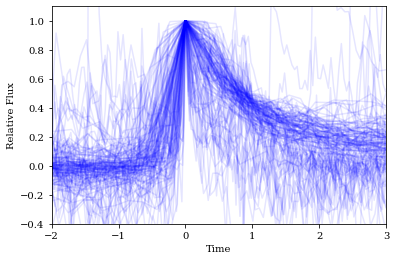

In [332]:
for i in range(0,len(m1_flares_dur_limit)):
        m1_x = (oneflare_x - time_max[i])/(t_halfs[i])
        m1_y = ((detrended_unmes)/(peaks[i]))
        plt.plot(m1_x,m1_y,color='b',alpha=0.1)



        plt.xlabel('Time')
        plt.ylabel('Relative Flux')
        #plt.ylim(-0.4,1)
        plt.xlim(-2,3)
        plt.ylim(-0.4,1.1)
        #plt.xlim(-5,20)
    


        #int_xvals = np.linspace(-10,20,steps)
        #int_yvals = np.interp(month1_xvals, m1_x, (detrended_unmes/peaks[i]))
        #plt.plot(int_xvals,int_yvals,'-x',color='orange',alpha=.3)
    #else:
        #print(i)


(0.004, 0.009)

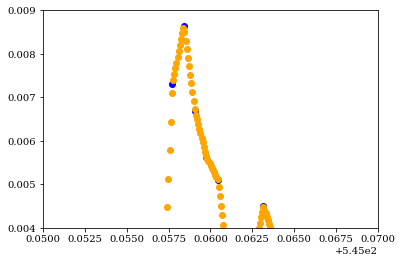

In [330]:

plt.scatter(oneflare_x,detrended_unmes,color='b')
plt.scatter(month1_xvals,month1_yinterp,color='orange')
plt.xlim(545.05,545.07)
plt.ylim(.004,.009)